In [278]:
from astropy.io import fits
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import norm, median_abs_deviation
from scipy.io import loadmat
from astropy.coordinates import Angle, SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import glob
import pandas as pd
import json
import os
import math

In [279]:
def fits_data_index(fits_file: str):
    '''
    Finds the location of a FITS file's data array.

    Parameters
    ----------
    fits_file : str
        The path of the FITS file to be searched.

    Returns
    -------
    int
        The index of the data array in the FITS file.
    '''

    file_index = 0

    #open FITS file
    try:
        file = fits.open(fits_file)
    except:
        print(f'Unable to open {fits_file}')

    info = file[file_index]
    data = info.data
    while data is None:
        #going through the indices of file to find the array
        try:
            file_index += 1
            info = file[file_index]
            data = info.data
        except:
            print(f'Error in locating data index of {fits_file}')

    return file_index

In [280]:
def gaussian_theta(coord, amp, sigma, theta, mu_x, mu_y):
    x, y = coord
    return amp * np.exp(-(((x-mu_x)*math.cos(theta)+(y-mu_y)*math.sin(theta))**2+(-(x-mu_x)*math.sin(theta)+(y-mu_y)*math.cos(theta))**2)/(2*sigma**2))

In [281]:
def region_stats(fits_file: str, center: list = [], radius: list = [], invert: bool = False, Gaussian: bool = True, internal: bool = True,\
                 outer_radius: float = None):
    '''
    Finds the statistics of a region of an image.

    The region can be the union of circles or the complement of such a region.

    The statistics are the region's maximum flux in Jy and its coordinates in pixels, the region's rms in Jy,
    the coordinates in pixels of the image's center, the image's beam size in arcseconds squared,
    the image's x- and y-axis lengths in arcseconds, and the area included in the mask in arcseconds squared.

    Parameters
    ----------
    fits_file : str
        The path of the FITS file that contains the image.
    center : list (optional)
        A list of center coordinates in units of pixels.
        If no center coordinates are given, eventually defaults to ((length of x-axis)/2, (length of y-axis)/2), rounded up.
    radius : list (optional)
        A list of search radii in units of arcsec.
        If no radius list is given, defaults to an empty list.
    invert : bool (optional)
        Whether to swap the inclusion and exclusion regions.
        If no value is given, defaults to False.

    Returns
    -------
    dict
        A dictionary with:
            float
                The region's maximum flux in Jy.
            tuple (int, int)
                The coordinates in pixels of the region's maximum flux.
            float
                The region's rms in Jy.
            tuple (int, int)
                The coordinates in pixels of the image's center.
            float
                The image's beam size in arcseconds squared.
            float
                The image's x-axis length in arcsec.
            float
                The image's y-axis length in arcsec.
            float
                The area included in the mask in arcseconds squared.

    Raises
    ------
    IndexError
        If center list and radius list are of different lengths.
    '''

    if center != [] and len(center) != len(radius):
        raise IndexError ('Center list and radius list are of different lengths')

    i = fits_data_index(fits_file)

    #open FITS file
    try:
        file = fits.open(fits_file)
    except:
        print(f'Unable to open {fits_file}')

    #extract data array
    info = file[i]
    data = info.data

    mad = float(median_abs_deviation(data[0].flatten()))
    sd_mad = float(norm.ppf(0.84) / norm.ppf(0.75) * mad) #estimate standard deviation from MAD

    #getting dimensions for array
    x_dim = info.header['NAXIS1']
    y_dim = info.header['NAXIS2']

    x_dist_array = np.tile(np.arange(x_dim),(y_dim, 1)) #array of each pixel's horizontal distance (in pixels) from y-axis
    y_dist_array = x_dist_array.T #array of each pixel's vertical distance (in pixels) from x-axis

    #keep center pixel coordinates if specified, set to default if unspecified
    center_pix = center
    field_center = (round(x_dim/2), round(y_dim/2))
    if center == []:
        center_pix = [field_center]
        if len(radius) > 1:
            center_pix = center_pix * len(radius)

    #find units of axes
    x_unit = info.header['CUNIT1']
    y_unit = info.header['CUNIT2']

    #find cell size (units of arcsec)
    x_cell_size = (Angle(info.header['CDELT1'], x_unit)).to(u.arcsec)
    y_cell_size = (Angle(info.header['CDELT2'], y_unit)).to(u.arcsec)

    #find beam size (unitless but in arcsec^2)
    beam_size = float(((np.pi/4) * info.header['BMAJ'] * info.header['BMIN'] * Angle(1, x_unit) * Angle(1, y_unit) / np.log(2)).to(u.arcsec**2)\
                / (u.arcsec**2))

    #find axis sizes
    x_axis_size = x_dim * x_cell_size
    y_axis_size = y_dim * y_cell_size

    #distance from center array
    dist_from_center =((((x_dist_array - center_pix[0][0])*x_cell_size)**2 + ((y_dist_array - center_pix[0][1])*y_cell_size)**2)**0.5)

    #boolean mask and apply
    mask = (dist_from_center <= radius[0] * u.arcsec)
    if len(center) > 1:
        for j in range(1, len(center)):
            dist_from_center = ((((x_dist_array - center_pix[j][0])*x_cell_size)**2 + ((y_dist_array - center_pix[j][1])*y_cell_size)**2)**0.5)
            mask = np.logical_or(mask, (dist_from_center <= radius[j] * u.arcsec))

    if invert:
        mask = np.logical_not(mask)

    if outer_radius is not None:
        dist_from_field_center = ((((x_dist_array - field_center[0])*x_cell_size)**2 + ((y_dist_array - field_center[1])*y_cell_size)**2)**0.5)
        outer_mask = (dist_from_field_center <= outer_radius * u.arcsec)
        mask = np.logical_and(mask, outer_mask)

    incl_area = float(mask.sum() * x_cell_size * y_cell_size / (u.arcsec)**2)
    excl_area = float(np.logical_not(mask).sum() * x_cell_size * y_cell_size / (u.arcsec)**2)

    masked_data = data[0][mask]

    #get peak
    try:
        peak = float(max(masked_data))
        print(f'before gauss: {peak}')
    except ValueError:
        print('No values after mask applied. Check inclusion and exclusion radii.')

    #find coordinates of peak
    peak_pix = np.where(data[0] == peak)
    peak_x = peak_pix[1][0]
    peak_y = peak_pix[0][0]
    peak_coord = (peak_x, peak_y)

    #fit for peak and coordinates assuming Gaussian
    #use data from 5x5 region if internal peak
    if Gaussian and internal and (peak_x - 2) >= 0 and (peak_x + 2) <= x_dim and (peak_y - 2) >= 0 and (peak_y + 2) <= y_dim:
        neg2_2 = data[0][peak_x - 2][peak_y + 2]
        neg2_1 = data[0][peak_x - 2][peak_y + 1]
        neg2_0 = data[0][peak_x - 2][peak_y]
        neg2_neg1 = data[0][peak_x - 2][peak_y - 1]
        neg2_neg2 = data[0][peak_x - 2][peak_y - 2]
        neg1_2 = data[0][peak_x - 1][peak_y + 2]
        neg1_1 = data[0][peak_x - 1][peak_y + 1]
        neg1_0 = data[0][peak_x - 1][peak_y]
        neg1_neg1 = data[0][peak_x - 1][peak_y - 1]
        neg1_neg2 = data[0][peak_x - 1][peak_y - 2]
        zero_2 = data[0][peak_x][peak_y + 2]
        zero_1 = data[0][peak_x][peak_y + 1]
        zero_neg1 = data[0][peak_x][peak_y - 1]
        zero_neg2 = data[0][peak_x][peak_y - 2]
        pos1_2 = data[0][peak_x + 1][peak_y + 2]
        pos1_1 = data[0][peak_x + 1][peak_y + 1]
        pos1_0 = data[0][peak_x + 1][peak_y]
        pos1_neg1 = data[0][peak_x + 1][peak_y - 1]
        pos1_neg2 = data[0][peak_x + 1][peak_y - 2]
        pos2_2 = data[0][peak_x + 2][peak_y + 2]
        pos2_1 = data[0][peak_x + 2][peak_y + 1]
        pos2_0 = data[0][peak_x + 2][peak_y]
        pos2_neg1 = data[0][peak_x + 2][peak_y - 1]
        pos2_neg2 = data[0][peak_x + 2][peak_y - 2]

        z_data = [neg2_2, neg2_1, neg2_0, neg2_neg1, neg2_neg2,\
                neg1_2, neg1_1, neg1_0, neg1_neg1, neg1_neg2,\
                zero_2, zero_1, peak, zero_neg1, zero_neg2,\
                pos1_2, pos1_1, pos1_0, pos1_neg1, pos1_neg2,\
                pos2_2, pos2_1, pos2_0, pos2_neg1, pos2_neg2]
        x_data = [-2]*5 + [-1]*5 + [0]*5 + [1]*5 + [2]*5
        y_data = [2, 1, 0, -1, -2]*5

        try:
            popt, pcov = curve_fit(gaussian_theta, (x_data, y_data), z_data, bounds=([peak,0,0,-1,-1],[float('inf'),float('inf'),2*np.pi,1,1]))
            amp, sigma, theta, mu_x, mu_y = popt
            peak = float(amp)
            print(f'after gauss: {peak}')
            print(f'mu_x: {mu_x}, mu_y: {mu_y}')
            peak_coord = (float(peak_x + mu_x), float(peak_y + mu_y))
        except RuntimeError:
            pass

    #use data from 3x3 region if external peak
    elif Gaussian and (not internal) and (peak_x - 1) >= 0 and (peak_x + 1) <= x_dim and (peak_y - 1) >= 0 and (peak_y + 1) <= y_dim:
        left_top = data[0][peak_x - 1][peak_y + 1]
        left_middle = data[0][peak_x - 1][peak_y]
        left_bottom = data[0][peak_x - 1][peak_y - 1]
        middle_top = data[0][peak_x][peak_y + 1]
        middle_bottom = data[0][peak_x][peak_y - 1]
        right_top = data[0][peak_x + 1][peak_y + 1]
        right_middle = data[0][peak_x + 1][peak_y]
        right_bottom = data[0][peak_x + 1][peak_y - 1]

        z_data = [left_top, left_middle, left_bottom, middle_top, peak, middle_bottom, right_top, right_middle, right_bottom]
        x_data = [-1]*3 + [0]*3 + [1]*3
        y_data = [1, 0, -1] * 3

        try:
            popt, pcov = curve_fit(gaussian_theta, (x_data, y_data), z_data, bounds=([peak,0,0,-1,-1],[float('inf'),float('inf'),2*np.pi,1,1]))
            amp, sigma, theta, mu_x, mu_y = popt
            peak = float(amp)
            peak_coord = (float(peak_x + mu_x), float(peak_y + mu_y))
        except RuntimeError:
            pass

    rms = float((np.var(masked_data))**0.5)

    stats = {'peak': peak, 'field_center': field_center, 'peak_coord': peak_coord, 'rms': rms, 'beam_size': beam_size,\
             'x_axis': float(x_axis_size / u.arcsec), 'y_axis': float(y_axis_size / u.arcsec), 'incl_area': incl_area, 'excl_area': excl_area,\
             'n_incl_meas': float(incl_area / beam_size), 'n_excl_meas': float(excl_area / beam_size), 'mad': mad, 'sd_mad': sd_mad}

    return stats

In [282]:
def calc_prob_from_rms_uncert(peak: float, rms: float, n_excl: float, n_incl: float = None):

    #calculate error for rms
    rms_err = rms * (n_excl)**(-1/2)

    #create normal distributions from rms and error for rms
    uncert = np.linspace(-5 * rms_err, 5 * rms_err, 100)
    uncert_pdf = norm.pdf(uncert, loc = 0, scale = rms_err)

    #sum and normalize to find probabilities
    if n_incl == None:
        return float(sum((norm.cdf((-1 * peak)/(rms + uncert)) * n_excl) * uncert_pdf) / sum(uncert_pdf))
    else:
        return float(sum((norm.cdf((-1 * peak)/(rms + uncert)) * n_incl) * uncert_pdf) / sum(uncert_pdf))

In [283]:
def prob_dict_from_rms_uncert(fits_file: str, center: list = [], rms: float = None, radius_buffer: float = 5.0, ext_threshold: float = None):

    i = fits_data_index(fits_file)

    #open FITS file
    try:
        file = fits.open(fits_file)
    except:
        print(f'Unable to open {fits_file}')

    #extract data array
    info = file[i]

    beam_fwhm = float((info.header['BMAJ'] * (Angle(1, info.header['CUNIT1'])).to(u.arcsec) / u.arcsec)) #unitless but in arcsec
    search_radius = beam_fwhm + radius_buffer #unitless but in arcsec

    #search for brightest internal peak
    int_stats1 = region_stats(fits_file=fits_file, center=center, radius=[search_radius], invert=False, Gaussian=True, internal=True)
    int_coord1 = int_stats1['peak_coord']
    int_peak1 = int_stats1['peak']
    n_incl = int_stats1['n_incl_meas'] #should be the same for all internal peaks
    field_center = int_stats1['field_center'] #in pixels
    mad = int_stats1['mad'] #should be the same for all peaks
    sd_mad = int_stats1['sd_mad'] #should be the same for all peaks

    #find external peaks and get their info
    center = [field_center]
    radius = [search_radius]

    ext_stats1 = region_stats(fits_file=fits_file, center=center, radius=radius, invert=True, Gaussian=False, internal=False)
    n_excl = ext_stats1['n_incl_meas'] #should be the same for all external peaks
    ext_peak1 = ext_stats1['peak']
    rms = ext_stats1['rms'] #can be changed later as we exclude more peaks
    ext_prob1 = calc_prob_from_rms_uncert(peak=ext_peak1, rms=rms, n_excl=n_excl)

    prob_dict = {'field_center': field_center, 'rms_val': None, 'mad': mad, 'sd_mad': sd_mad, 'n_incl_meas': n_incl, 'n_excl_meas': n_excl,\
                 'fwhm': beam_fwhm, 'incl_radius': search_radius,\
                 'int_peak_val': [], 'int_peak_coord': [], 'int_prob': [], 'int_snr': [],\
                 'ext_peak_val': [], 'ext_peak_coord': [], 'ext_prob': [], 'ext_snr': [], 'next_ext_peak': None}

    #update ext_threshold if needed
    int_snr1 = int_peak1 / rms
    print(f'snr: {int_snr1} = {int_peak1} / {rms}')
    if ext_threshold == None:
        if int_snr1 < 20:
            ext_threshold = 1e-3
        else:
            ext_threshold = 1e-6

    if ext_prob1 < ext_threshold:
        ext_significant = True
    else:
        prob_dict['next_ext_peak'] = ext_peak1
        ext_significant = False

    while ext_significant:
        ext_stats = region_stats(fits_file=fits_file, center=center, radius=radius, invert=True, Gaussian=False, internal=False)
        peak = ext_stats['peak']
        rms = ext_stats['rms']

        ext_prob = calc_prob_from_rms_uncert(peak=peak, rms=rms, n_excl=n_excl)
        if ext_prob < ext_threshold:
            ext_stats = region_stats(fits_file=fits_file, center=center, radius=radius, invert=True, Gaussian=True, internal=False)
            coord = ext_stats['peak_coord']
            prob_dict['ext_peak_val'].append(peak)
            prob_dict['ext_peak_coord'].append(coord)
            prob_dict['ext_prob'].append(ext_prob)
            prob_dict['ext_snr'].append(peak / rms)
            center.append(coord)
            radius.append(beam_fwhm)
        else:
            prob_dict['next_ext_peak'] = peak
            ext_significant = False

    prob_dict['rms_val'] = rms

    #find prob for 1st internal peak using updated rms
    prob_dict['int_peak_val'].append(int_peak1)
    prob_dict['int_peak_coord'].append(int_coord1)
    int_prob1 = calc_prob_from_rms_uncert(peak=int_peak1, rms=rms, n_excl=n_excl, n_incl=n_incl)
    prob_dict['int_prob'].append(int_prob1)
    prob_dict['int_snr'].append(int_peak1 / rms)

    int_significant = True
    #treat 1st internal peak kind of like an external peak and get rid of search radius so we can look inside
    center = [int_coord1]
    radius = [beam_fwhm]

    #find internal peaks in addition to 1st internal peak
    while int_significant:
        int_stats = region_stats(fits_file=fits_file, center=center, radius=radius, invert=True, Gaussian=True, internal=True,\
                                 outer_radius=search_radius)
        int_peak = int_stats['peak']
        int_prob = calc_prob_from_rms_uncert(peak=int_peak, rms=rms, n_excl=n_excl, n_incl=n_incl)
        if int_prob < 0.01 and (int_peak > int_snr1 / 100):
            int_coord = int_stats['peak_coord']
            prob_dict['int_peak_val'].append(int_peak)
            prob_dict['int_peak_coord'].append(int_coord)
            prob_dict['int_prob'].append(int_prob)
            prob_dict['int_snr'].append(int_peak / rms)
            center.append(int_coord)
            radius.append(beam_fwhm)
        else:
            int_significant = False

    return prob_dict

In [284]:
def get_prob_rms_est_from_ext(prob_dict: dict):
    '''
    Using the rms estimated from the value of the exclusion region's maximum flux,
    finds the probability of detecting the inclusion region's maximum flux if there were no source in the inclusion region,
    the probability of detecting the exclusion region's maximum flux if there were no source in the exclusion region, and other statistics.

    The estimated rms is that the probability of finding such an external peak,
    assuming no source in the exclusion region, is 1.
    Note: this implies that the external probability will always be 1.

    The other statistics include the following as calculated using the rms estimated as described above:
    the exclusion region's rms in Jy, the inclusion region's signal to noise ratio,
    and the external region's signal to noise ratio.

    The remaining statisitcs include the following as calculated using the rms taken directly from the image:
    the inclusion region's maximum flux in Jy and its coordinates in pixels,
    the exclusion region's maximum flux in Jy and its coordinates in pixels, the exclusion region's rms in Jy,
    the number of measurements in the inclusion region, the number of measurements in the exclusion region,
    the coordinates in pixels of the image's center, and the radii in pixels of the inclusion zones,
    the inclusion region's signal to noise ratio, and the external region's signal to noise ratio.

    Parameters
    ----------
    prob_list : list
        The list of statistics, as outputted by get_prob_image_rms(), for an image.

    Returns
    -------
    list
        A list with:
            dict(s)
                A dictionary with the following, found using the rms taken directly from the image:
                    float
                        The probability of detecting the inclusion region's maximum flux if there were no source in the inclusion region.
                    float
                        The probability of detecting the exclusion region's maximum flux if there were no source in the exclusion region.
                    float
                        The inclusion region's maximum flux in Jy.
                    tuple (int, int)
                        The coordinates in pixels of the inclusion region's maximum flux.
                    float
                        The exclusion region's maximum flux in Jy.
                    tuple (int, int)
                        The coordinates in pixels of the exclusion region's maximum flux.
                    float
                        The exclusion region's rms in Jy.
                    float
                        The number of measurements in the inclusion region.
                    float
                        The number of measurements in the exclusion region.
                    tuple (int, int)
                        The coordinates in pixels of the image's center.
                    list
                        A list with:
                            float(s)
                                The radii in pixels of inclusion zones.
                    float
                        The inclusion region's signal to noise ratio.
                    float
                        The exclusion region's signal to noise ratio.
            dict
                A dictionary with the following, found using the rms estimated as described above:
                    float
                        The probability of detecting the inclusion region's maximum flux if there were no source in the inclusion region.
                    float
                        The probability of detecting the exclusion region's maximum flux if there were no source in the exclusion region.
                    float
                        The exclusion region's rms in Jy.
                    float
                        The inclusion region's signal to noise ratio.
                    float
                        The exclusion region's signal to noise ratio.
    '''
    int_peak_val = prob_dict['int_peak_val']
    ext_peak_val = prob_dict['next_ext_peak']
    n_incl_meas = prob_dict['n_incl_meas']
    n_excl_meas = prob_dict['n_excl_meas']

    excl_sigma = -1 * norm.ppf(1/n_excl_meas)
    rms_val = ext_peak_val / excl_sigma

    prob_dict['calc_rms_val'] = float(rms_val)
    prob_dict['calc_ext_prob'] = float(norm.cdf((-1 * ext_peak_val)/(rms_val))) * n_excl_meas
    prob_dict['calc_ext_snr'] = float(excl_sigma)
    for i in range(len(int_peak_val)):
        if i == 0:
            prob_dict['calc_int_prob'] = [float(norm.cdf((-1 * int_peak_val[i])/(rms_val))) * n_incl_meas]
            prob_dict['calc_int_snr'] = [float(int_peak_val[i] / rms_val)]
        else:
            prob_dict['calc_int_prob'].append(float(norm.cdf((-1 * int_peak_val[i])/(rms_val))) * n_incl_meas)
            prob_dict['calc_int_snr'].append(float(int_peak_val[i] / rms_val))

    return prob_dict

In [285]:
def summary(fits_file: str, radius_buffer: float = 5.0, ext_threshold: float = None,\
            short_dict: bool = True, plot: bool = True, save_path: str = ''):
    '''
    Summarizes an image's statistics into a shorter dictionary, a more detailed dictionary, and/or a plot,
    with an option to save the plot as a png.

    Parameters
    ----------
    fits_file : str
        The path of the FITS file that contains the image.
    radius_buffer : float (optional)
        The amount of buffer, in arcsec, to add to the beam FWHM to get the initial search radius.
        If no value is given, defaults to 5 arcsec.
    ext_threshold : float (optional)
        The probability that an external peak must be below for it to be considered an external source.
        If no value is given, defaults to 0.001.
    short_dict : bool (optional)
        Whether to return the short dictionary of statistics.
        If no value is given, defaults to True.
    full_list : bool (optional)
        Whether to return the more detailed list of statistics.
        If no value is given, defaults to False.
    plot : bool (optional)
        Whether to plot the image and statistics.
        If no value is given, defaults to True.
    save_path : str (optional)
        The path to which the plot will be saved.
        If no value is given, defaults to '' and no image is saved.

    Returns
    -------
    dict (if requested)
        A shorter dictionary with:
            float
                The probability, found using the rms taken directly from the image,
                of detecting the inclusion region's maximum flux if there were no source in the inclusion region.
            list
                A list with:
                    float(s)
                        The probabilities, found using the rms taken directly from the image,
                        of detecting the exclusion regions' maximum flux if there were no source in the exclusion regions.
                        If there are multiple entries in this list,
                        they are the probabilities as the exclusion region becomes increasingly small
                        as external peaks deemed significant are added to the inclusion region.
            float
                The inclusion region's maximum flux in Jy.
            tuple (float, float)
                The coordinates in relative arcsec of the inclusion region's maximum flux.
            list
                A list of with:
                    float(s)
                        The exclusion regions' maximum fluxes in Jy.
                        If there are multiple entries in this list,
                        they are the maxmimum fluxes as the exclusion region becomes increasingly small
                        as external peaks deemed significant are added to the inclusion region.
            list
                A list with:
                    tuple(s) (float, float)
                        The coordinates in relative arcsec of the exclusion regions' maximum fluxes.
                        If there are multiple entires in this list,
                        they are the coordinates as the exclusion region becomes increasingly small
                        as external peaks deemed significant are added to the inclusion region.
            float
                The exclusion region's rms in Jy. This uses the final (smallest) exclusion region.
            float
                The number of measurements in the inclusion region.
            float
                The number of measurements in the exclusion region.
            tuple (int, int)
                The coordinates in relative arcsec of the image's center. Should be (0, 0).
            list
                A list with:
                    float(s):
                        The radii in arcsec of inclusion zones.
            float
                The inclusion region's signal to noise ratio.
            list
                A list with:
                    float(s)
                        The exclusion regions' signal to noise ratios.
            float
                The probability, found using the rms estimated from the value of the exclusion region's maximum flux,
                of detecting the inclusion region's maximum flux if there were no source in the inclusion region.
            float
                The probability, found using the rms estimated from the value of the exclusion region's maximum flux,
                of detecting the exclusion region's maximum flux if there were no source in the exclusion region.
            float
                The rms in Jy estimated from the value of the exclusion region's maximum flux.
            float
                The inclusion region's signal to noise ratio,
                found using the rms estimated from the value of the exclusion region's maximum flux.
            float
                The exclusion region's signal to noise ratio,
                found using the rms estimated from the value of the exclusion region's maximum flux.
    list (if requested)
        A more detailed list with:
            dict(s)
                A dictionary with the following, found using the rms taken directly from the image:
                    float
                        The probability of detecting the inclusion region's maximum flux if there were no source in the inclusion region.
                    float
                        The probability of detecting the exclusion region's maximum flux if there were no source in the exclusion region.
                    float
                        The inclusion region's maximum flux in Jy.
                    tuple (float, float)
                        The coordinates in relative arcsec of the inclusion region's maximum flux.
                    float
                        The exclusion region's maximum flux in Jy.
                    tuple (float, float)
                        The coordinates in relative arcsec of the exclusion region's maximum flux.
                    float
                        The exclusion region's rms in Jy.
                    float
                        The number of measurements in the inclusion region.
                    float
                        The number of measurements in the exclusion region.
                    tuple (float, float)
                        The coordinates in relative arcsec of the image's center. Should be (0.0, 0.0).
                    list
                        A list with:
                            float(s)
                                The radii in arcsec of inclusion zones.
                    float
                        The inclusion region's signal to noise ratio.
                    float
                        The exclusion region's signal to noise ratio.
            dict
                A dictionary with the following, found using the rms estimated as described above:
                    float
                        The probability of detecting the inclusion region's maximum flux if there were no source in the inclusion region.
                    float
                        The probability of detecting the exclusion region's maximum flux if there were no source in the exclusion region.
                    float
                        The exclusion region's rms in Jy.
                    float
                        The inclusion region's signal to noise ratio.
                    float
                        The exclusion region's signal to noise ratio.
    '''
    info = (get_prob_rms_est_from_ext(prob_dict_from_rms_uncert(fits_file=fits_file, radius_buffer=radius_buffer, ext_threshold=ext_threshold)))

    center = info['field_center']

    header_data = fits.getheader(fits_file)
    pixel_scale = Angle(header_data['CDELT1'], header_data['CUNIT1']).to_value('arcsec')

    int_x_coords = []
    int_y_coords = []
    int_peak_coords = info['int_peak_coord']
    n_int_peaks = len(int_peak_coords)
    for i in range(n_int_peaks):
        #normalized internal peak coordinates
        int_x_coords.append((int_peak_coords[i][0] - center[0]) * pixel_scale)
        int_y_coords.append((int_peak_coords[i][1] - center[1]) * pixel_scale)
    int_x_coords = np.array(int_x_coords)
    int_y_coords = np.array(int_y_coords)

    incl_radius = info['incl_radius'] #unitless but in arcsec already

    x_coords = []
    y_coords = []
    ext_peak_coords = info['ext_peak_coord']
    n_ext_peaks = len(ext_peak_coords)
    for i in range(n_ext_peaks):
        #normalized external peak coordinates
        x_coords.append((ext_peak_coords[i][0] - center[0]) * pixel_scale)
        y_coords.append((ext_peak_coords[i][1] - center[1]) * pixel_scale)

    fwhm = info['fwhm']

    if plot:
        #plt.rcParams['font.family'] = 'serif'
        #plt.rcParams['font.serif'] = ['Times New Roman']
        plt.rcParams['font.size'] = 15
        plt.rcParams['hatch.linewidth'] = 0.5
        plt.rcParams['figure.dpi'] = 60

        image_data = fits.getdata(fits_file)
        shape = image_data.shape

        while len(shape) > 2:
            image_data = image_data[0]
            shape = image_data.shape

        plt.set_cmap('inferno')
        fig, ax = plt.subplots(figsize=(6.7,5.1))

        plt.plot(int_x_coords, int_y_coords, 'wo', fillstyle='none', markersize=15)
        plt.plot(int_x_coords, int_y_coords, 'kx', fillstyle='none', markersize=15/np.sqrt(2))

        for i in range(n_int_peaks):
            int_circle = patches.Circle((int_x_coords[i], int_y_coords[i]), fwhm * pixel_scale, edgecolor='lime', fill=False)
            ax.add_artist(int_circle)

        int_circle = patches.Circle((0, 0), incl_radius, edgecolor='c', fill=False)
        ax.add_artist(int_circle)

        if n_ext_peaks > 0:
            x_coords = np.array(x_coords)
            y_coords = np.array(y_coords)
            plt.plot(x_coords, y_coords, 'ko', fillstyle='none', markersize=15)
            plt.plot(x_coords, y_coords, 'wx', fillstyle='none', markersize=15/np.sqrt(2))

            for i in range(n_ext_peaks):
                ext_circle = patches.Circle((x_coords[i], y_coords[i]), fwhm * pixel_scale, edgecolor='lime', fill=False)
                ax.add_artist(ext_circle)

        int_snr = info['int_snr'][0]

        x_min = ((0 - center[0]) - 0.5) * pixel_scale
        y_min = ((0 - center[1]) - 0.5) * pixel_scale
        x_max = ((image_data.shape[0] -  center[0]) - 0.5) * pixel_scale
        y_max = ((image_data.shape[1] -  center[1]) - 0.5) * pixel_scale

        beam = patches.Ellipse((x_min*0.88, y_min*0.92), Angle(header_data['BMIN'], header_data['CUNIT1']).to_value('arcsec'),\
                               Angle(header_data['BMAJ'], header_data['CUNIT1']).to_value('arcsec'), fill=True, facecolor='w',\
                                edgecolor='k', angle=header_data['BPA'], hatch='/////', lw=1)
        ax.add_artist(beam)

        title = fits_file[fits_file.rindex('/')+1:fits_file.index('.fits')]
        ax.text(x_min*0.96, y_max*0.96, f'Source: {title}\nInternal Candidate SNR: {int_snr:.2f}', horizontalalignment='left', verticalalignment='top',\
                fontsize=10, bbox=dict(facecolor='w'))

        plt.imshow(image_data, extent=[x_min, x_max, y_min, y_max], origin='lower')

        plt.xlabel('Relative RA Offset [arcsec]', fontsize=15)
        plt.ylabel('Relative Dec Offset [arcsec]', fontsize=15)

        jy_to_mjy = lambda x, pos: '{}'.format(round(x*1000, 1))
        fmt = ticker.FuncFormatter(jy_to_mjy)

        cbar = plt.colorbar(shrink=0.8, format=fmt)
        cbar.ax.set_ylabel('Intensity [mJy/beam]', fontsize=15, rotation=270, labelpad=24)

        if save_path != '':
            try:
                file = fits_file
                while '/' in file:
                    file = file[file.index('/')+1:]
                file = file.replace('.fits', '')
                if ext_threshold == None:
                    ext_threshold = 'default'
                file += f'_rb{radius_buffer}_et{ext_threshold}'
                if save_path[-1] != '/':
                    save_path = save_path + '/'
                plt.savefig(f'{save_path}{file}.jpg')
            except:
                print('Error saving figure. Double check path entered.')

    if short_dict:
        short_info = info

        int_peaks = []
        for i in range(n_int_peaks):
            int_peaks.append((float(int_x_coords[i]), float(int_y_coords[i])))

        ext_peaks = []
        for i in range(n_ext_peaks):
            ext_peaks.append((float(x_coords[i]), float(y_coords[i])))

        if n_ext_peaks == 0:
            ext_peaks = 'No significant external peak'
            short_info['ext_peak_val'] = 'No significant external peak'
            short_info['ext_snr'] = 'No significant external peak'
            short_info['ext_prob'] = 'No significant external peak'

        short_info = info
        short_info['int_peak_coord'] = int_peaks
        short_info['ext_peak_coord'] = ext_peaks
        short_info['field_center'] = (0,0)

        del short_info['next_ext_peak']

        return short_info

    else:
        return

In [286]:
def significant(fits_file: str, threshold: float = 0.01, radius_buffer: float = 5.0, ext_threshold: float = None):
    '''
    Finds whether a significant source was detected in a field's center region.

    Parameters
    ----------
    fits_file : str
        The path of the FITS file that contains the image.
    threshold : float (optional)
        The threshold for a significant detection.
        If the probability of detecting the center region's maximum flux assuming no source in the image
        is less than this threshold, then the detection is deemed significant.
        If no value is given, defaults to 0.01.
    radius_buffer : float (optional)
        The amount of buffer, in arcsec, to add to the beam FWHM to get the initial search radius.
        If no value is given, defaults to 5 arcsec.
    ext_threshold : float (optional)
        The probability that an external peak must be below for it to be considered an external source.
        If no value is given, defaults to 0.001.

    Returns
    -------
    bool : Whether a significant source was detected in the field's center region.

    Raises
    ------
    ValueError
        If threshold is not between 0 and 1, inclusive.
    '''

    #make sure reasonable input
    if not (threshold >= 0 and threshold <= 1):
        raise ValueError('Threshold must be between 0 and 1, inclusive.')

    summ = summary(fits_file, radius_buffer=radius_buffer, ext_threshold=ext_threshold, short_dict=True, plot=False)
    return (summ['int_prob'][0] < threshold and summ['calc_int_prob'][0] < threshold)

In [287]:
def make_catalog(fits_file: str, threshold: float = 0.01, radius_buffer: float = 5.0, ext_threshold: float = None):
    '''
    Summarizes information on any significant point sources detected in an image.

    Parameters
    ----------
    fits_file : str
        The path of the FITS file that contains the image.
    threshold : float (optional)
        The threshold for a significant detection.
        If the probability of detecting the center region's maximum flux assuming no source in the image
        is less than this threshold, then the detection is deemed significant.
        If no value is given, defaults to 0.01.
    radius_buffer : float (optional)
        The amount of buffer, in arcsec, to add to the beam FWHM to get the initial search radius.
        If no value is given, defaults to 5 arcsec.
    ext_threshold : float (optional)
        The probability that an external peak must be below for it to be considered an external source.
        If no value is given, defaults to 0.001.

    Returns
    -------
    dict
        A dictionary with:
            dict(s)
                A dictionary with:
                    str
                        The name of the target object of the observation.
                    str
                        The date and time of the observation.
                    str
                        The name of the FITS file with the image.
                    Angle
                        The restoring beam major axis.
                    Angle
                        The restoring beam minor axis.
                    Angle
                        The restoring beam position angle.
                    float
                        The uncertainty in flux density measurements. The rms excluding any significant sources and a small circular region around them.
                    float
                        The flux density of the detected point source.
                    SkyCoord
                        The location of the detected point source.
                    bool
                        Whether the detected point source is in the initial search region.
    '''

    summ = summary(fits_file, radius_buffer=radius_buffer, ext_threshold=ext_threshold, short_dict=True, plot=False)

    header_data = fits.getheader(fits_file)
    name = header_data['OBJECT']
    obs_date_time = header_data['DATE-OBS']
    bmaj = header_data['BMAJ']
    bmin = header_data['BMIN']
    bpa = header_data['BPA']
    ctype1 = header_data['CTYPE1']
    crval1 = header_data['CRVAL1']
    cunit1 = header_data['CUNIT1']
    ctype2 = header_data['CTYPE2']
    crval2 = header_data['CRVAL2']
    cunit2 = header_data['CUNIT2']
    ctype3 = header_data['CTYPE3']
    crval3 = header_data['CRVAL3']
    cunit3 = header_data['CUNIT3']

    freq = 'Not found'
    if ctype3 == 'FREQ':
        freq = str(crval3) + cunit3

    #assume beam axes in same units as CUNIT1 and CUNIT2 and BPA in degrees
    beam_maj_axis = Angle(bmaj, cunit1)
    beam_min_axis = Angle(bmin, cunit1)
    bpa_rad = math.radians(bpa)

    interesting_sources = {}
    field_info = {'Field Name': name, 'Obs Date Time': obs_date_time, 'File Name': fits_file[fits_file.rindex('/')+1:],\
                    'Beam Maj Axis': round(float(beam_maj_axis.to(u.arcsec)/u.arcsec), 3) * u.arcsec,\
                    'Beam Min Axis': round(float(beam_min_axis.to(u.arcsec)/u.arcsec), 3) * u.arcsec,\
                    'Beam Pos Angle': round(bpa, 3) * u.deg,\
                    'Freq': freq, 'Flux Uncert': round(summ['rms_val'] * 1000, 3) * u.mJy,}

    n_int_sources = len(summ['int_peak_val'])
    if type(summ['ext_peak_val']) == str:
        n_ext_sources = 0
    else:
        n_ext_sources = len(summ['ext_peak_val'])

    ra_index = 0
    dec_index = 1

    if 'RA' in ctype1:
        ra = crval1
    elif 'RA' in ctype2:
        ra = crval2
        ra_index = 1
    else:
        raise ValueError('No RA in image')

    if 'DEC' in ctype1:
        dec = crval1
        dec_index = 0
    elif 'DEC' in ctype2:
        dec = crval2
    else:
        raise ValueError('No dec in image')

    if cunit1 != cunit2:
        raise ValueError('Axes have different units')

    center = SkyCoord(ra, dec, unit=cunit1)

    pt_source_count = 1

    for i in range(n_int_sources):
        if (summ['int_prob'][i] < threshold and summ['calc_int_prob'][i] < threshold):
            info = field_info.copy()
            info['Flux Density'] = round(summ[f'int_peak_val'][i] * 1000, 3) * u.mJy

            snr = summ[f'int_snr'][i]
            b_min_uncert = float(bmaj / snr)
            b_maj_uncert = float(bmin / snr)
            info['RA Uncert'] = round(b_min_uncert*abs(math.sin(bpa)) + b_maj_uncert*abs(math.cos(bpa)), 3) * u.arcsec
            info['Dec Uncert'] = round(b_maj_uncert*abs(math.sin(bpa)) + b_min_uncert*abs(math.cos(bpa)), 3) * u.arcsec

            ra_offset = summ[f'int_peak_coord'][i][ra_index] * u.arcsec
            dec_offset = summ[f'int_peak_coord'][i][dec_index] * u.arcsec
            coord = center.spherical_offsets_by(ra_offset, dec_offset)

            ra_str = str(coord.ra)
            dec_str = str(coord.dec)

            try:
                m_index = ra_str.index('m')
                s_index = ra_str.index('s')
                ra_seconds = ra_str[m_index + 1: s_index]
                ra_str = ra_str[:m_index + 1] + str(round(float(ra_seconds), 2)) + 's'
            except:
                pass

            try:
                m_index = dec_str.index('m')
                s_index = dec_str.index('s')
                dec_seconds = dec_str[m_index + 1: s_index]
                dec_str = dec_str[:m_index + 1] + str(round(float(dec_seconds), 2)) + 's'
            except:
                pass

            info['Coord RA'] = ra_str
            info['Coord Dec'] = dec_str
            info['Internal'] = True

            key = f'Source {pt_source_count}'
            interesting_sources[key] = info
            pt_source_count +=1

    for i in range(n_ext_sources):
        info = field_info.copy()
        info['Flux Density'] = round(summ[f'ext_peak_val'][i] * 1000, 3) * u.mJy

        snr = summ[f'ext_snr'][i]
        b_min_uncert = float(bmaj / snr)
        b_maj_uncert = float(bmin / snr)
        info['RA Uncert'] = round(b_min_uncert*abs(math.sin(bpa)) + b_maj_uncert*abs(math.cos(bpa)), 3) * u.arcsec
        info['Dec Uncert'] = round(b_maj_uncert*abs(math.sin(bpa)) + b_min_uncert*abs(math.cos(bpa)), 3) * u.arcsec

        ra_offset = summ[f'ext_peak_coord'][i][ra_index] * u.arcsec
        dec_offset = summ[f'ext_peak_coord'][i][dec_index] * u.arcsec
        coord = center.spherical_offsets_by(ra_offset, dec_offset)

        ra_str = str(coord.ra)
        dec_str = str(coord.dec)

        try:
            m_index = ra_str.index('m')
            s_index = ra_str.index('s')
            ra_seconds = ra_str[m_index + 1: s_index]
            ra_str = ra_str[:m_index + 1] + str(round(float(ra_seconds), 2)) + 's'
        except:
            pass

        try:
            m_index = dec_str.index('m')
            s_index = dec_str.index('s')
            dec_seconds = dec_str[m_index + 1: s_index]
            dec_str = dec_str[:m_index + 1] + str(round(float(dec_seconds), 2)) + 's'
        except:
            pass

        info['Coord RA'] = ra_str
        info['Coord Dec'] = dec_str
        info['Internal'] = False

        key = f'Source {pt_source_count}'
        interesting_sources[key] = info
        pt_source_count +=1

    if interesting_sources == {}:
        return
    else:
        return interesting_sources

In [288]:
def combine_catalogs(catalog_1: dict, catalog_2: dict):
    '''
    Combines two catalogs in the format returned by make_catalog() into a single catalog of the same format.

    Parameters
    ----------
    catalog_1 : dict
        The catalog to which the other catalog will be "appended."
    catalog_2 : dict
        The catalog to "append" to the other catalog.

    Returns
    -------
    dict
        A dictionary of the combined catalogs in the same catalog format.
    '''

    shift = len(catalog_1)
    for key, value in catalog_2.items():
        new_number = int(key.replace('Source ', ''))
        new_key = f'Source {new_number + shift}'
        catalog_1[new_key] = value
    return catalog_1

In [289]:
def start_html(html_path):
    '''
    Starts source_info.html, in which source information can be stored.
    '''

    with open(html_path, 'w') as html_file:
        start = '''
        <!DOCTYPE html>
        <html>
        <style>
        img.field {
        width: 40%;
        height: 40%
        }
        img.bp {
        width: 20%;
        height: 20%
        }
        img.gain {
        width: 45%;
        height: 45%
        }
        .centered-large-text {
        text-align: center;
        font-size: 36px;
        }
        </style>
        <body>
        '''
        html_file.write(start)
        html_file.close()

In [290]:
def obs_info_to_html(json_file: str, html_path: str):
    '''
    Appends observation information table to source_info.html using information from a .json file.

    Parameters
    ----------
    json_file : str
        The path of the .json file that contains the observation information.
    '''

    with open(html_path, 'a') as html_file:
        try:
            with open(json_file, 'r') as file:
                obs_dict = json.load(file)

            #cleaning up obs_dict
            for key, value in obs_dict.items():
                if type(value) == list:
                    string = ', '.join(value)
                    obs_dict[key] = [string]
            obs_id = obs_dict.pop('obsID')
            base_name = obs_dict.pop('basename')

            df = pd.DataFrame(obs_dict)
            df_transposed = df.T

            html_table = df_transposed.to_html()

            html_file.write(f'<p class=\'centered-large-text\'>Source Information for {base_name} (ObsID {obs_id}) </p>')
            html_file.write(html_table)
        except:
            html_file.write('<p> Error generating observation information table. </p>')

In [291]:
def ap_eff_to_html(html_path, matlab: str):

    try:
        data = loadmat(matlab)
        ap_eff_array = data['apEffCorr']

        n_ants = len(ap_eff_array)
        panda_dict = {}

        for ant in range(n_ants):
            ant_eff = {}
            ant_eff['RxA LSB'] = float(ap_eff_array[ant][0])
            ant_eff['RxA USB'] = float(ap_eff_array[ant][1])
            ant_eff['RxB LSB'] = float(ap_eff_array[ant][2])
            ant_eff['RxB USB'] = float(ap_eff_array[ant][3])
            panda_dict[f'Ant {ant+1}'] = ant_eff

        df = pd.DataFrame.from_dict(panda_dict)
        df_transposed = df.T
        html_table = df_transposed.to_html()

        with open(html_path, 'a') as html_file:
            html_file.write(html_table)
    except:
        print('Error with aperture efficiency data.')

In [292]:
def calibration_plots(html_path, matlab: str):

    plt.rcdefaults()
    plt.rcParams['figure.dpi'] = 60
    plt.rcParams['font.size'] = 8


    data = loadmat(matlab)
    gt = data['gainTime']
    gws = data['gainWinSoln']
    gcs = data['gainChanSoln']
    gain_type = data['gainType']

    n_times = len(gt)
    n_ants = len(gws[0])
    n_spws = len(gws[0][0])
    n_chans = len(gcs[0][0][0])

    utc_midpts = []
    for t in range(len(gt)):
        midpt = 0.5 * (gt[t][0].real + gt[t][0].imag)
        utc_midpts.append((midpt%1)*24)

    colors = ['blue','r','y','purple','orange','g','m','c']

    chan_bit = 7
    if all(bit == 0 for bit in (gain_type & (2**chan_bit))):
        chan_bit = 0
    spw_bit = 6
    if all(bit == 0 for bit in (gain_type & (2**spw_bit))):
        spw_bit = 1

    #plotting bandpass gain solutions for amplitude and phase
    fig, ax = plt.subplots(nrows=n_ants, ncols=1, sharex=True, figsize=(3,8))
    fig2, ax2 = plt.subplots(nrows=n_ants, ncols=1, sharex=True, figsize=(3,8))

    max_amp = 0

    for time in range(n_times):
        if (gain_type & (2**chan_bit))[time] != 0:
            for ant in range(n_ants):

                #shifting for cosmetics
                pos = ax[ant].get_position()
                pos.x0 += 0.05
                pos.x1 += 0.05
                ax[ant].set_position(pos)
                pos2 = ax2[ant].get_position()
                pos2.x0 += 0.06
                pos2.x1 += 0.06
                ax2[ant].set_position(pos2)

                #no x axis ticks
                ax[ant].xaxis.set_tick_params(labelbottom=False)
                ax2[ant].xaxis.set_tick_params(labelbottom=False)


                for spw in range(n_spws):
                    amp_to_plot = [abs(a) for a in gcs.copy()[time][ant][spw]]
                    pha_to_plot = [np.angle(p, deg=True) for p in gcs.copy()[time][ant][spw]]
                    if max(amp_to_plot) > max_amp:
                        max_amp = max(amp_to_plot)

                    x_axis = np.arange(spw * n_chans + 1, (1 + spw) * n_chans + 1)

                    ax[ant].scatter(x_axis, amp_to_plot, c=colors[spw], s=20, marker='x', linewidths=1.5)
                    ax2[ant].scatter(x_axis, pha_to_plot, c=colors[spw], s=20, marker='x', linewidths=1.5)

                    ax[ant].yaxis.set_label_position('right')
                    ax2[ant].yaxis.set_label_position('right')
                    ax[ant].set_ylabel(f'Ant{ant+1}')
                    ax2[ant].set_ylabel(f'Ant{ant+1}')

    plt.setp(ax, yticks=np.arange(0, max_amp+1, 0.5))
    plt.setp(ax2, yticks=[-180,-120,-60,0,60,120,180])
    fig.suptitle('Bandpass gain solutions for amplitude', y=0.92)
    fig2.suptitle('Bandpass gain solutions for phase', y=0.92)
    fig.supxlabel('Full antenna bandwidth', y=0.07)
    fig2.supxlabel('Full antenna bandwidth', y=0.07)
    fig.supylabel('Gain amplitude')
    fig2.supylabel('Gain phase')

    html_folder = os.path.dirname(html_path)

    fig.savefig(os.path.join(html_folder, 'bp_amp.jpg'))
    fig2.savefig(os.path.join(html_folder, 'bp_pha.jpg'))

    plt.close()

    #plotting gain solutions for amplitude and phase
    n_rows = math.ceil(n_ants / 2)
    n_cols = 2

    fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, sharex=True, figsize=(5.7,4))
    fig2, ax2 = plt.subplots(nrows=n_rows, ncols=n_cols, sharex=True, figsize=(5.7,4))

    max_amp, min_time, max_time = 0, float('inf'), 0

    for spw in range(n_spws):
        for ant in range(n_ants):
            amp_to_plot, pha_to_plot = [], []
            times = []

            if ant < n_rows:
                row, col = ant, 0

                #shifting for cosmetics
                pos = ax[row, col].get_position()
                pos.x0 -= 0.005
                pos.x1 -= 0.005
                ax[row, col].set_position(pos)
                pos2 = ax2[row, col].get_position()
                pos2.x0 -= 0.005
                pos2.x1 -= 0.005
                ax2[row, col].set_position(pos2)
            else:
                row, col = ant % n_rows, 1

            for time in range(n_times):
                if gain_type[time] & (2**6) != 0:
                    amp_val = abs((gws.copy())[time][ant][spw])
                    pha_val = np.angle((gws.copy())[time][ant][spw], deg=True)
                    amp_to_plot.append(amp_val)
                    pha_to_plot.append(pha_val)

                    if amp_val > max_amp:
                        max_amp = amp_val

                    t = utc_midpts[time]
                    if t < min_time:
                        min_time = t
                    if t > max_time:
                        max_time = t

                    times.append(t)

            ax[row, col].scatter(times, amp_to_plot, c=colors[spw], s=4, marker='D')
            ax2[row, col].scatter(times, pha_to_plot, c=colors[spw], s=4, marker='D')

            ax[row, col].yaxis.set_label_position('right')
            ax2[row, col].yaxis.set_label_position('right')
            ax[row, col].set_ylabel(f'Ant{ant+1}')
            ax2[row, col].set_ylabel(f'Ant{ant+1}')
            amp_to_plot, pha_to_plot = [], []

    plt.setp(ax, xticks=np.arange(min_time//1, math.ceil(max_time), 1), yticks=np.arange(0, max_amp+1, 0.5))
    plt.setp(ax2, xticks=np.arange(min_time//1, math.ceil(max_time), 1), yticks=[-180,-120,-60,0,60,120,180])
    fig.suptitle('Gain solutions for amplitude')
    fig2.suptitle('Gain solutions for phase')
    fig.supxlabel('UT hours')
    fig2.supxlabel('UT hours')
    fig.supylabel('Gain amplitude')
    fig2.supylabel('Gain phase')

    fig.savefig(os.path.join(html_folder, 'g_amp.jpg'))
    fig2.savefig(os.path.join(html_folder, 'g_pha.jpg'))

    plt.close()

In [293]:
def fig_to_html(html_path: str, fits_file: str, radius_buffer: float = 5.0, ext_threshold: float = None):
    '''
    Appends source figures to source_info.html.

    Parameters
    ----------
    fits_file : str
        The path of the FITS file that contains the image.
    radius_buffer : float (optional)
        The amount of buffer, in arcsec, to add to the beam FWHM to get the initial search radius.
        If no value is given, defaults to 5 arcsec.
    ext_threshold : float (optional)
        The probability that an external peak must be below for it to be considered an external source.
        If no value is given, defaults to 0.001.
    '''

    with open(html_path, 'a') as html_file:
        try:
            summary(fits_file=fits_file, radius_buffer=radius_buffer, ext_threshold=ext_threshold,\
                    short_dict=False, plot=True, save_path=os.path.dirname(html_path))

            #getting full path
            file = fits_file
            while '/' in file:
                file = file[file.index('/')+1:]
            file = file.replace('.fits', '')
            if ext_threshold == None:
                ext_threshold = 'default'
            file += f'_rb{radius_buffer}_et{ext_threshold}'
            full_path = f'./{file}.jpg'

            html_figure = f'''
            <img class=\'field\' src=\'{full_path}\'>
            <br>
            '''

            html_file.write(html_figure)
        except:
            html_file.write(f'<p> Error generating figure for {fits_file}. </p>')

In [294]:
def catalog_to_html(catalog: dict, html_path):
    '''
    Appends source information table to source_info.html.

    Parameters
    ----------
    catalog : dict
        A catalog in the format returned by make_catalog().
    '''

    df = pd.DataFrame.from_dict(catalog)
    df_transposed = df.T
    html_table = df_transposed.to_html()

    with open(html_path, 'a') as html_file:
        html_file.write(html_table)

In [295]:
def end_html(html_path: str):
    '''
    Ends source_info.html, in which source information can be stored.
    '''

    with open(html_path, 'a') as html_file:

        end = '''
        </body>
        </html>
        '''

        html_file.write(end)

In [296]:
def full_html_and_txt(folder: str, threshold: float = 0.01, radius_buffer: float = 5.0, ext_threshold: float = None):
    '''
    From a folder of FITS files, creates source_info.html with observation information table, source figures, and source information table
    and creates interesting_field.txt with names of objects with any (possibly) interesting detections.

    Parameters
    ----------
    folder : str
        The path of the folder containing the FITS files to be analyzed.
    threshold : float (optional)
        The threshold for a significant detection.
        If the probability of detecting the center region's maximum flux assuming no source in the image
        is less than this threshold, then the detection is deemed significant.
        If no value is given, defaults to 0.01.
    radius_buffer : float (optional)
        The amount of buffer, in arcsec, to add to the beam FWHM to get the initial search radius.
        If no value is given, defaults to 5 arcsec.
    ext_threshold : float (optional)
        The probability that an external peak must be below for it to be considered an external source.
        If no value is given, defaults to 0.001.
    '''

    html_path = os.path.join(folder, 'index.html')
    matlab_file = os.path.join(folder, 'gains.mat')

    start_html(html_path)

    json_file = os.path.join(folder, 'polaris.json')

    obs_info_to_html(json_file, html_path)

    ap_eff_to_html(html_path, matlab_file)

    try:
        calibration_plots(html_path, matlab_file)

        with open(html_path, 'a') as html_file:
            html_gain_info = f'''
            <img class=\'bp\' src=\'./bp_amp.jpg'\'>
            <img class=\'bp\' src=\'./bp_pha.jpg'\'>
            <br>
            <img class=\'gain\' src=\'./g_amp.jpg'\'>
            <img class=\'gain\' src=\'./g_pha.jpg'\'>
            <br>
            '''
            html_file.write(html_gain_info)
    except:
        print('Error with gain calibration information.')

    final_catalog = {}
    with open(json_file, 'r') as file:
        obs_dict = json.load(file)

    sci_targs = [targ.lower() for targ in obs_dict['sciTargs']]
    pol_cals = [cal.lower() for cal in obs_dict['polCals']]
    with open(os.path.join(folder, 'interesting_fields.txt'), 'w') as txt:
        for file in glob.glob(os.path.join(folder, '*.fits')):
            obj = fits.getheader(file)['OBJECT']
            if obj.lower() not in pol_cals:
                fig_to_html(html_path, file, radius_buffer=radius_buffer, ext_threshold=ext_threshold)
            if obj.lower() in sci_targs:
                catalog = make_catalog(file, threshold=threshold, radius_buffer=radius_buffer, ext_threshold=ext_threshold)

                #add field name to .txt file if it is a science target with a significant detection in the initial inclusion region
                if catalog != None:
                    for key, value in catalog.items():
                        if value['Internal'] == True:
                            txt.write(f'{obj}\n')
                    final_catalog = combine_catalogs(final_catalog, catalog)

    catalog_to_html(final_catalog, html_path)
    end_html(html_path)

    plt.close('all')

In [297]:
def low_level_csv(folder, csv_path = './low_level.csv'):

    master_catalog = None
    old_df = None
    str_obs_id = 'Unknown'

    try:
        old_df = pd.read_csv(csv_path)
    except:
        pass

    try:
        json_file = os.path.join(folder, 'polaris.json')
        with open(json_file, 'r') as file:
            obs_dict = json.load(file)

            #cleaning up obs_dict
            for key, value in obs_dict.items():
                if type(value) == list:
                    string = ', '.join(value)
                    obs_dict[key] = [string]
            obs_id = obs_dict.pop('obsID')
            str_obs_id = f'id{obs_id}'
        if old_df is not None:
            old_df = old_df[(old_df['Obs ID']) != str_obs_id] #removing old or outdated entries
    except Exception as e:
        print(f'Error with obsID: {e}. WARNING: Old/outdated data may not be deleted.')

    if old_df is not None:
        master_catalog = (old_df.T).to_dict()

    for file in glob.glob(os.path.join(folder, '*.fits')):
        try:
            catalog = make_catalog(file)
            if catalog is not None:
                for value in catalog.values():
                    value['Obs ID'] = str_obs_id
                    value['Source ID'] = 'Unknown'
                if master_catalog is None:
                    master_catalog = catalog
                elif catalog is not None:
                    master_catalog = combine_catalogs(master_catalog, catalog)
        except Exception as e:
            print(f'Error for {file}: {e}')

    df = pd.DataFrame.from_dict(master_catalog)
    df = df.T
    df.to_csv(csv_path, mode='w', header=True, index=False)

In [298]:
def high_level_csv(low_level_path = './low_level.csv', high_level_path = './high_level.csv'):

    low_df = pd.read_csv(low_level_path)
    unique_sources = None

    try:
        unique_sources = pd.read_csv(high_level_path).to_dict(orient='list')
    except:
        pass

    #coarse matching
    for row in range(len(low_df)):
        if unique_sources is not None:
            ra = low_df['Coord RA'].iloc[row]
            dec = low_df['Coord Dec'].iloc[row]
            coord1 = SkyCoord(ra, dec)
            fwhm = low_df['Beam Maj Axis'].iloc[row]
            fwhm1_val = float(fwhm.replace(' arcsec', ''))
            source_ids = unique_sources['Source ID']
            matched  = False
            while not matched:
                for i in range(len(source_ids)):
                    coord2 = SkyCoord(unique_sources['RA'][i], unique_sources['Dec'][i])
                    sep = coord1.separation(coord2)
                    fwhm2_val = float(unique_sources['FWHM'][i].replace(' arcsec', ''))
                    max_sep = (fwhm1_val * fwhm2_val)**(1/2) * u.arcsec
                    matched = (sep <= max_sep)
                    if matched:
                        low_df.loc[row, 'Source ID'] = source_ids[i]
                        break
                break
            if not matched:
                last_id = source_ids[-1]
                next_number = str(int(last_id.replace('id', '')) + 1)
                next_number = '0' * (4 - len(next_number)) + next_number
                next_id = f'id{next_number}'
                source_ids.append(next_id)
                unique_sources['RA'].append(ra)
                unique_sources['Dec'].append(dec)
                unique_sources['FWHM'].append(fwhm)
                low_df.loc[row, 'Source ID'] = next_id
                unique_sources['Ambiguous Ties'].append('Unknown')

        else:
            ra = low_df['Coord RA'].iloc[row]
            dec = low_df['Coord Dec'].iloc[row]
            fwhm = low_df['Beam Maj Axis'].iloc[row]
            unique_sources = {'Source ID': ['id0001'], 'RA': [ra], 'Dec': [dec], 'FWHM': [fwhm], 'Ambiguous Ties': ['Unknown']}
            low_df.loc[row, 'Source ID'] = 'id0001'

    #further refining matches
    #getting average values
    for i in range(len(unique_sources['Source ID'])):
        temp_df = low_df[(low_df['Source ID']) == unique_sources['Source ID'][i]]
        ra_list = [Angle(ra, u.deg) for ra in temp_df['Coord RA']]
        dec_list = [Angle(dec, u.deg) for dec in temp_df['Coord Dec']]
        fwhm_list = [Angle(fwhm, u.arcsec) for fwhm in temp_df['Beam Maj Axis']]
        avg_ra = sum(ra_list) / len(ra_list)
        avg_dec = sum(dec_list) / len(dec_list)
        geo_avg_fwhm = math.prod(fwhm_list) ** (1/len(fwhm_list))
        unique_sources['RA'][i] = avg_ra
        unique_sources['Dec'][i] = avg_dec
        unique_sources['FWHM'][i] = geo_avg_fwhm
    #comparing averaged unique sources
    new_sources = unique_sources.copy()
    to_skip = []
    for i in range(len(unique_sources['Source ID'])):
        if len(unique_sources['Source ID']) > 1 and i not in to_skip:
            coord1 = SkyCoord(unique_sources['RA'][i], unique_sources['Dec'][i])
            for j in range(i + 1, len(unique_sources['Source ID'])):
                if j not in to_skip:
                    coord2 = SkyCoord(unique_sources['RA'][j], unique_sources['Dec'][j])
                    sep = coord1.separation(coord2)
                    if sep <= Angle(1, u.arcsec): #1 arcsec or less apart, same source
                        #match found, update averages
                        to_skip.append(j)
                        num_i = len(low_df[(low_df['Source ID']) == unique_sources['Source ID'][i]])
                        num_j = len(low_df[(low_df['Source ID']) == unique_sources['Source ID'][j]])
                        new_sources['RA'][i] = (unique_sources['RA'][i] * num_i + unique_sources['Ra'][j] * num_j) / (num_i + num_j)
                        new_sources['Dec'][i] = (unique_sources['Dec'][i] * num_i + unique_sources['Dec'][j] * num_j) / (num_i + num_j)
                        new_sources['FWHM'][i] = ((unique_sources['FWHM'][i]**num_i) * (unique_sources['FWHM'][j]**num_j))**(1/(num_i + num_j))
                        if new_sources['Ambiguous Ties'][i] == 'Unknown':
                            new_sources['Ambiguous Ties'][i] = 'None found'
                        if new_sources['Ambiguous Ties'][j] == 'Unknown':
                            new_sources['Ambiguous Ties'][j] = 'None found'
                        #update low_df
                        indices = low_df.index[low_df['Source ID'] == unique_sources['Source ID'][j]]
                        low_df.loc[indices, 'Source ID'] = unique_sources['Source ID'][i]
                        to_skip.append(j)
                    elif sep > Angle(1, u.arcsec) and sep < Angle(5, u.arcsec): #more than 1 but less than 5 arcsec apart, ambiguous
                        if new_sources['Ambiguous Ties'][i] == 'Unknown' or new_sources['Ambiguous Ties'][i] == 'None found':
                            new_sources['Ambiguous Ties'][i] = unique_sources['Source ID'][j]
                        elif unique_sources['Source ID'][j] not in new_sources['Ambiguous Ties'][i]:
                            new_sources['Ambiguous Ties'][i] += '_{}'.format(unique_sources['Source ID'][j])
                        if new_sources['Ambiguous Ties'][j] == 'Unknown' or new_sources['Ambiguous Ties'][j] == 'None found':
                            new_sources['Ambiguous Ties'][j] = unique_sources['Source ID'][i]
                        elif unique_sources['Source ID'][i] not in new_sources['Ambiguous Ties'][j]:
                            new_sources['Ambiguous Ties'][j] += '_{}'.format(unique_sources['Source ID'][i])
                    else: #5 or more arcsec apart, not the same source
                        if new_sources['Ambiguous Ties'][i] == 'Unknown':
                            new_sources['Ambiguous Ties'][i] = 'None found'
                        if new_sources['Ambiguous Ties'][j] == 'Unknown':
                            new_sources['Ambiguous Ties'][j] = 'None found'
    to_skip.sort(reverse=True)
    for k in to_skip:
        del new_sources['Source ID'][k]
        del new_sources['RA'][k]
        del new_sources['Dec'][k]
        del new_sources['FWHM'][k]
        del new_sources['Ambiguous Ties'][k]
    df = pd.DataFrame.from_dict(new_sources)
    df.to_csv(high_level_path, mode='w', header=True, index=False)
    low_df.to_csv(low_level_path, mode='w', header=True, index=False)

before gauss: 0.0018029502825811505
after gauss: 0.04986705488346005
mu_x: 0.26153929939606707, mu_y: -0.19596283183885443
before gauss: 0.006583510898053646
snr: 62.86926972718488 = 0.04986705488346005 / 0.0007931864820420742
before gauss: 0.006583510898053646
before gauss: 0.006583510898053646
before gauss: 0.002912077819928527
before gauss: 0.0017896863864734769
after gauss: 0.0017896870007932742
mu_x: 0.5482144862002092, mu_y: 0.577377046329257


{'field_center': (0, 0),
 'rms_val': 0.0007672652718611062,
 'mad': 0.000521551410201937,
 'sd_mad': 0.0007689678178559412,
 'n_incl_meas': 20.420300911272722,
 'n_excl_meas': 601.9524528146684,
 'fwhm': 3.26538144,
 'incl_radius': 8.26538144,
 'int_peak_val': [0.04986705488346005],
 'int_peak_coord': [(1.246079163922272, -5.61784482112389)],
 'int_prob': [0.0],
 'int_snr': [64.99323859986616],
 'ext_peak_val': [0.006583510898053646],
 'ext_peak_coord': [(-0.6717755684288294, -18.079684661862622)],
 'ext_prob': [6.217169705782555e-13],
 'ext_snr': [8.300079548890277],
 'calc_rms_val': 0.0009917820759848288,
 'calc_ext_prob': 1.0000000000000004,
 'calc_ext_snr': 2.9362073488138667,
 'calc_int_prob': [0.0],
 'calc_int_snr': [50.28025419187235]}

<Figure size 384x288 with 0 Axes>

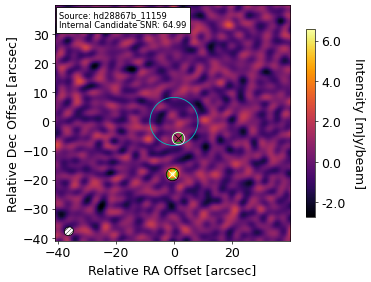

In [299]:
summary('../data/multi_track/hd28867b_11159.fits')

before gauss: 0.0017725310754030943
after gauss: 0.0017725310754030945
mu_x: 0.4250941414096941, mu_y: 0.11531035677200815
before gauss: 0.010683788917958736
snr: 2.004782481491947 = 0.0017725310754030945 / 0.0008841513190418482
before gauss: 0.010683788917958736
before gauss: 0.010683788917958736
before gauss: 0.0030916938558220863
before gauss: 0.0012069916119799018
after gauss: 0.02153367759169012
mu_x: 0.2399105706504166, mu_y: -0.23473315044282578
before gauss: 0.0011982251890003681
after gauss: 0.06176654858689076
mu_x: -0.2860152179928689, mu_y: -0.2198351289056646
before gauss: 0.0011412075255066156
after gauss: 0.043122046812378044
mu_x: 0.24884955545461834, mu_y: 0.2586244992526215
before gauss: 0.0010272085200995207
after gauss: 0.0011375263688468342
mu_x: 0.7704818319608845, mu_y: -0.3033188672364169


{'field_center': (0, 0),
 'rms_val': 0.00082370825111866,
 'mad': 0.0005518586840480566,
 'sd_mad': 0.0008136524218637984,
 'n_incl_meas': 19.813071504083663,
 'n_excl_meas': 551.803299833358,
 'fwhm': 3.4466479199999998,
 'incl_radius': 8.44664792,
 'int_peak_val': [0.0017725310754030945,
  0.02153367759169012,
  0.06176654858689076,
  0.043122046812378044],
 'int_peak_coord': [(0.7852086040302407, -5.446337284323962),
  (0.6831748303587123, 2.0746137681946952),
  (-2.3615394438738737, 7.592694199861931),
  (3.9940231840637725, -2.0614499412570697)],
 'int_prob': [0.3151097018485498, 1.0367054101706463e-108, 0.0, 0.0],
 'int_snr': [2.1518918536943867,
  26.14235994655354,
  74.98595346472125,
  52.351116738013665],
 'ext_peak_val': [0.010683788917958736],
 'ext_peak_coord': [(-0.6476634772085349, -18.280688074802104)],
 'ext_prob': [3.795236437105149e-26],
 'ext_snr': [12.083665643949638],
 'calc_rms_val': 0.0010627592254885698,
 'calc_ext_prob': 1.0000000000000004,
 'calc_ext_snr': 2

<Figure size 384x288 with 0 Axes>

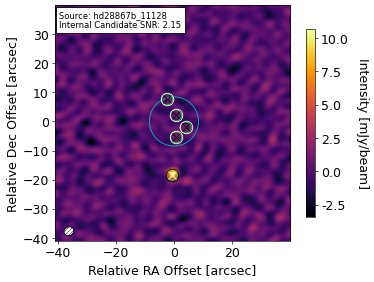

In [300]:
summary('../data/multi_track/hd28867b_11128.fits')

In [301]:
#s = summary('../data/250611_03:56:34/1310+323_full.fits', plot=False)
#for key, value in s.items():
#    print(f'{key}: {value}')

In [302]:
#%%timeit
#full_html_and_txt('../data/250611_03:56:34')

In [303]:
#%load_ext line_profiler

In [304]:
#%lprun -f full_html_and_txt full_html_and_txt('../data/250611_03:56:34/')

In [305]:
#make_catalog('/reduction/karto/SMA/polaris_test/250103_05:25:18/g232.6207+00.9959_full.fits')